In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download glove file

In [ ]:
# !pip install gdown

In [ ]:
# import gdown

# file_id = '1-4E3dyjIhg_UxUWkrTlGLd5AfOKxeMuN'  # Replace with your file ID
# output_path = '/content/drive/MyDrive/ASC/glove.txt'

# url = f'https://drive.google.com/uc?id={file_id}'
# gdown.download(url, output_path, quiet=False)


# Import Libraries

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import numpy as np
import pandas as pd
import pickle
import csv
import math
import torch
import keras
import os
import gc
import tensorflow as tf
from nltk.tokenize import word_tokenize
from torch import nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence
from keras.models import Sequential , Model
from keras.layers import LSTM, Bidirectional, Dense, Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from scipy.special import softmax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# Read dataset

In [ ]:
csv_file_path = "/content/drive/MyDrive/ASC/reviews ADS Courses.csv"
df_data = pd.read_csv(csv_file_path)
df_data.head()

,review,processed_review,aspect,label
0,The instructor did not really do a good enough...,teacher really good enough job setting stage e...,the teacher,0
1,Thank you. Instructor Mis Summer and Coursera,thank teacher mi summer coursera,the teacher,0
2,When instructor was speaking or showing exampl...,teacher speaking showing example screen always...,the teacher,0
3,"With the instructors accent, I had difficulty ...",teacher accent difficulty understanding everyt...,the teacher,0
4,This is a very good course for complete beginn...,good course complete beginner provides basic k...,the teacher,0


# Data Visualization

In [ ]:
temp = df_data.loc[df_data['aspect'] == 'the teacher', 'label']
unique_values, counts = np.unique(temp, return_counts=True)
# Print unique values and their respective counts
for value, count in zip(unique_values, counts):
    print(f'Value {value}: {count} samples')

Value 0: 742 samples
Value 1: 742 samples
Value 2: 742 samples


In [ ]:
temp = df_data.loc[df_data['aspect'] == 'the course', 'label']
unique_values, counts = np.unique(temp, return_counts=True)

# Print unique values and their respective counts
for value, count in zip(unique_values, counts):
    print(f'Value {value}: {count} samples')

Value 0: 15437 samples
Value 1: 15829 samples
Value 2: 15829 samples


# number of unique words in dataset

In [ ]:
df_data['processed_review'] = df_data['processed_review'].fillna('')

# Convert all entries to strings
df_data['processed_review'] = df_data['processed_review'].astype(str)

# Tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_data['processed_review'].tolist())

# Calculate the total number of tokens (words)
total_words = sum(len(sentence.split()) for sentence in df_data['processed_review'].tolist())

print("Total number of words in the dataset:", total_words)
vocab_size = total_words

Total number of words in the dataset: 686161


# load glove embeddings vectors

In [ ]:

# def load_glove_vectors(file_path):
#     word_vectors = {}
#     with open(file_path, 'r', encoding='utf-8') as file:
#         # Get the total number of lines in the file for tqdm
#         total_lines = sum(1 for line in file)
#         file.seek(0)  # Reset file pointer to the beginning

#         # Initialize tqdm with the total number of lines
#         with tqdm(total=total_lines, desc="Loading GloVe Vectors", unit="line") as pbar:
#             for line in file:
#                 values = line.split()
#                 word = values[0]
#                 vector = np.asarray(values[1:], dtype='float32')
#                 word_vectors[word] = vector
#                 pbar.update(1)  # Update the progress bar

#     return word_vectors

# glove_file = '/content/drive/MyDrive/ASC/glove.txt'
# glove_vectors = load_glove_vectors(glove_file)

In [ ]:
# len(glove_vectors)

# calculate the longest review

In [ ]:
sentences = df_data['processed_review'].tolist()

In [ ]:
from nltk.tokenize import word_tokenize
max_len = max(len(word_tokenize(sent.lower())) for sent in sentences)
max_len

466

# using glove for embeddings for words in all reviews

In [ ]:
# sentences_embedding = []

# for sen in sentences:
#     words_sentence_embedding = []
#     words = word_tokenize(sen.lower())
#     for word in words:
#         embedding_vector = glove_vectors.get(word)
#         if embedding_vector is not None and len(embedding_vector) > 0:
#             words_sentence_embedding.append(embedding_vector)
#     sentences_embedding.append(words_sentence_embedding)

In [ ]:
# len(sentences)

In [ ]:
# sentences[0]

In [ ]:
# words = word_tokenize(sentences[0].lower())
# len(words)

In [ ]:
# (len(sentences_embedding[0]))

# save embedding glove in pikle file

In [ ]:
# with open('/content/drive/MyDrive/ASC/glove_embedding.pkl', 'wb') as f:
#     pickle.dump(sentences_embedding, f)

# read embedding glove from pikle file

In [ ]:
# objects_glove_position = []
# with (open("/content/drive/MyDrive/ASC/glove_embedding.pkl", "rb")) as openfile:
#     while True:
#         try:
#             objects_glove_position.append(pickle.load(openfile))
#         except EOFError:
#             break

In [ ]:
# len(objects_glove_position)
# for i in objects_glove_position :
#     print(len(i))

In [ ]:
# len(objects_glove_position[0])

# relative position attention embedding

In [ ]:
# class RelativeGlobalAttention(nn.Module):
#     def __init__(self, d_model, num_heads, max_len=1024, dropout=0.1):
#         super().__init__()
#         d_head, remainder = divmod(d_model, num_heads)
#         if remainder:
#             raise ValueError(
#                 "incompatible `d_model` and `num_heads`"
#             )
#         self.max_len = max_len
#         self.d_model = d_model
#         self.num_heads = num_heads
#         self.key = nn.Linear(d_model, d_model)
#         self.value = nn.Linear(d_model, d_model)
#         self.query = nn.Linear(d_model, d_model)
#         self.dropout = nn.Dropout(dropout)
#         self.Er = nn.Parameter(torch.randn(max_len, d_head))
#         self.register_buffer(
#             "mask",
#             torch.tril(torch.ones(max_len, max_len))
#             .unsqueeze(0).unsqueeze(0)
#         )
#         # self.mask.shape = (1, 1, max_len, max_len)


#     def forward(self, x):
#         # x.shape == (batch_size, seq_len, d_model)
#         batch_size, seq_len, _ = x.shape

#         if seq_len > self.max_len:
#             raise ValueError(
#                 "sequence length exceeds model capacity"
#             )

#         k_t = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
#         # k_t.shape = (batch_size, num_heads, d_head, seq_len)
#         v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
#         q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
#         # shape = (batch_size, num_heads, seq_len, d_head)

#         start = self.max_len - seq_len
#         Er_t = self.Er[start:, :].transpose(0, 1)
#         # Er_t.shape = (d_head, seq_len)
#         QEr = torch.matmul(q, Er_t)
#         # QEr.shape = (batch_size, num_heads, seq_len, seq_len)
#         Srel = self.skew(QEr)
#         # Srel.shape = (batch_size, num_heads, seq_len, seq_len)

#         QK_t = torch.matmul(q, k_t)
#         # QK_t.shape = (batch_size, num_heads, seq_len, seq_len)
#         attn = (QK_t + Srel) / math.sqrt(q.size(-1))
#         mask = self.mask[:, :, :seq_len, :seq_len]
#         # mask.shape = (1, 1, seq_len, seq_len)
#         attn = attn.masked_fill(mask == 0, float("-inf"))
#         # attn.shape = (batch_size, num_heads, seq_len, seq_len)
#         attn = F.softmax(attn, dim=-1)
#         out = torch.matmul(attn, v)
#         # out.shape = (batch_size, num_heads, seq_len, d_head)
#         out = out.transpose(1, 2)
#         # out.shape == (batch_size, seq_len, num_heads, d_head)
#         out = out.reshape(batch_size, seq_len, -1)
#         # out.shape == (batch_size, seq_len, d_model)
#         return self.dropout(out)


#     def skew(self, QEr):
#         # QEr.shape = (batch_size, num_heads, seq_len, seq_len)
#         padded = F.pad(QEr, (1, 0))
#         # padded.shape = (batch_size, num_heads, seq_len, 1 + seq_len)
#         batch_size, num_heads, num_rows, num_cols = padded.shape
#         reshaped = padded.reshape(batch_size, num_heads, num_cols, num_rows)
#         # reshaped.size = (batch_size, num_heads, 1 + seq_len, seq_len)
#         Srel = reshaped[:, :, 1:, :]
#         # Srel.shape = (batch_size, num_heads, seq_len, seq_len)
#         return Srel


# test for relative position attention embedding

In [ ]:
# sentence = "i like to eat pizza"

# # Tokenize the sentence (you may need to use a tokenizer based on your use case)
# tokens = sentence.split()

# # Suppose you have word embeddings for each word in the sentence
# # For example, create a random tensor as embeddings (for demonstration purposes)
# embedding_size = 300  # Same as the d_model used in RelativeGlobalAttention
# word_embeddings = torch.randn(len(tokens), embedding_size)

# # Create an instance of the RelativeGlobalAttention class
# num_heads = 12
# attention_layer = RelativeGlobalAttention(embedding_size, num_heads)

# # List to store relative positional embeddings for each word
# relative_position_embeddings = []

# # Iterate through each word's embedding and apply the attention mechanism
# for i in range(len(tokens)):
#     # Get the embedding for the current word
#     word_embedding = word_embeddings[i].unsqueeze(0).unsqueeze(0)  # Reshape to (1, 1, d_model)

#     # Apply the attention mechanism to get relative positional embeddings
#     attention_output = attention_layer(word_embedding)

#     # Append the relative positional embedding for the current word to the list
#     relative_position_embeddings.append(attention_output.squeeze(0).squeeze(0))

# # Convert the list of relative positional embeddings to a torch tensor
# relative_position_embeddings = torch.stack(relative_position_embeddings)

# # The relative_position_embeddings tensor now contains the embeddings of relative positions
# print(relative_position_embeddings.shape)


# apply relative position embedding on all the words of the all reviews

In [ ]:
# num_heads = 12
# embedding_size = 300

# attention_layer = RelativeGlobalAttention(embedding_size, num_heads)

In [ ]:
# sentences_relative_positional_embedding=[]
# for embedding in objects_glove_position :
#     for sen_emb in embedding:
#         words_relative_positional_sentence_embedding=[]
#         for word_emb in sen_emb :
# #             print(len(word_emb))
#             embedding_vector = torch.tensor(word_emb).unsqueeze(0).unsqueeze(0)
# #             print(embedding_vector)
#             attention_output = attention_layer(embedding_vector)
#             words_relative_positional_sentence_embedding.append(attention_output.squeeze(0).squeeze(0).detach().numpy())
#         sentences_relative_positional_embedding.append(words_relative_positional_sentence_embedding)



In [ ]:
# type(sentences_relative_positional_embedding[0][0])

In [ ]:

# (sentences_relative_positional_embedding[0][0]).shape

# save embedding in pikle file

In [ ]:
# with open('/content/drive/MyDrive/ASC/relative_position_embedding.pkl', 'wb') as f:
#     pickle.dump(sentences_relative_positional_embedding, f)

# read embedding from pikle file

In [ ]:
# objects_realtive_position = []
# with (open("/content/drive/MyDrive/ASC/relative_position_embedding.pkl", "rb")) as openfile:
#     while True:
#         try:
#             objects_realtive_position.append(pickle.load(openfile))
#         except EOFError:
#             break

In [ ]:
# for relative in objects_realtive_position :
#     print(len(relative))

# concatenate glove embedding and relative embedding

In [ ]:
# for item1, item2 in zip(objects_glove_position, objects_realtive_position):
#     sentences_new_embedding=[]
#     for sen1,sen2 in zip(item1, item2):
#         sen_new_embedding=[]
#         if len(sen1)==len(sen2):
#               for word1,word2 in zip(sen1,sen2):
#                 combined_vector = np.concatenate((word1, word2))
#                 sen_new_embedding.append(combined_vector)
#         if len(sen1)>len(sen2):
#             for i in range(len(sen1)-len(sen2)):
#                 sen2.append(np.zeros(300))
#             for word1,word2 in zip(sen1,sen2):
#                 combined_vector = np.concatenate((word1, word2))
#                 sen_new_embedding.append(combined_vector)

#         if len(sen2)>len(sen1):
#             for i in range(len(sen2)-len(sen1)):
#                 sen1.append(np.zeros(300))
#             for word1,word2 in zip(sen1,sen2):
#                 combined_vector = np.concatenate((word1, word2))
#                 sen_new_embedding.append(combined_vector)

#         sentences_new_embedding.append(sen_new_embedding)

In [ ]:
# objects_glove_position = 0
# objects_realtive_position = 0

In [ ]:
# np.array(sentences_new_embedding).shape

In [ ]:
# np.array(sentences_new_embedding[0])

In [ ]:
# np.array(sentences_new_embedding[0]).shape

In [ ]:
# embedings_all_words = []
# number_of_words = 0
# for sent in (sentences_new_embedding):
#     number_of_words = number_of_words + len(sent)
#     for word in sent :
#          embedings_all_words.append(word)



In [ ]:
# np.array(embedings_all_words).shape

In [ ]:
# embedings_all_words = np.array(embedings_all_words).reshape(672316, 600)
# embedings_all_words.shape

(672316, 600)

In [ ]:
# number_of_words

# bi-lstm for the reviews

In [ ]:
# # Define your vocabulary size and embedding dimensions
# vocab_size = number_of_words  # Define your vocabulary size
# embedding_dim = 600  # Define your embedding dimensions

# # from keras.models import Model

# # Create the Bi-LSTM model
# model = Sequential()
# model.add(Embedding(input_dim=vocab_size, weights=[embedings_all_words], output_dim=embedding_dim, input_length=max_len, mask_zero=True))
# model.add(Bidirectional(LSTM(300, return_sequences=True)))  # Set return_sequences=True to get sequences instead of a single output
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model (you can use the appropriate loss and optimizer for your task)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Print the model summary
# model.summary()

# embedding_layer = model.layers[1]  # Get the Embedding layer (the first layer)
# embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)

# # Now, you can use embedding_model to get the hidden states


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 466, 600)          403389600 
                                                                 
 bidirectional_2 (Bidirecti  (None, 466, 600)          2162400   
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 466, 1)            601       
                                                                 
Total params: 405552601 (1.51 GB)
Trainable params: 405552601 (1.51 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# number of aspects words from aspect 1 (teacher) in each review  

In [ ]:
# aspect_1 = "the teacher"
# aspect_2 = "the course"
# aspects = ["the teacher","the course"]
# aspect1_for_all_sentence =[]
# aspect2_for_all_sentence =[]
# label_aspect_1 = []
# label_aspect_2 = []


# label1 = df_data["labeles_aspect1"].tolist()
# label2 = df_data["labeles_aspect2"].tolist()
# for index,sen in enumerate(sentences):
#   if 'teacher' in sen:
#     aspect1_for_all_sentence.append(sen)
#     label_aspect_1.append(label1[index])
#   if 'course' in sen:
#     aspect2_for_all_sentence.append(sen)
#     label_aspect_2.append(label2[index])

In [ ]:
# aspects_words_1 = ["the teacher"]*len(label_aspect_1)
# aspects_words_2 = ["the course"]*len(label_aspect_2)

In [ ]:
# len(aspects_words_1)

In [ ]:
# print(len(sentences))
# print(len(aspect1_for_all_sentence))
# print(len(aspect2_for_all_sentence))
# print(len(sentences) - (len(aspect1_for_all_sentence)+len(aspect2_for_all_sentence)))
# print(aspect1_for_all_sentence[0])
# print(aspect2_for_all_sentence[0])

# embedding for aspect1 set words

In [ ]:
# words =  word_tokenize(aspect_1.lower())
# embedding_words = []
# for index,word in enumerate(words):
#     glove_emb = glove_vectors.get(word)
#     word_embedding = torch.tensor(glove_emb).unsqueeze(0).unsqueeze(0)
#     attention_output = attention_layer(word_embedding)
#     att_embedding = attention_output.squeeze(0).squeeze(0).detach().numpy()
#     con = np.concatenate([glove_emb, att_embedding], axis=0)
#     embedding_words.append(con)

# embedding_aspect_1 = embedding_words

In [ ]:
# print(np.array(embedding_aspect_1).shape)

# embedding for aspect2 set words

In [ ]:
# words =  word_tokenize(aspect_2.lower())
# embedding_words = []
# for index,word in enumerate(words):
#     glove_emb = glove_vectors.get(word)
#     word_embedding = torch.tensor(glove_emb).unsqueeze(0).unsqueeze(0)  # Reshape to (1, 1, d_model)
#     attention_output = attention_layer(word_embedding)
#     att_embedding = attention_output.squeeze(0).squeeze(0).detach().numpy()
#     con = np.concatenate([glove_emb, att_embedding], axis=0)
#     embedding_words.append(con)

# embedding_aspect_2 = embedding_words

In [ ]:
# print(np.array(embedding_aspect_2).shape)

# embedding for all aspects words

In [ ]:
# embedding_for_all_aspects = []
# embedding_for_all_aspects.extend(embedding_aspect_1)
# embedding_for_all_aspects.extend(embedding_aspect_2)
# np.array(embedding_for_all_aspects).shape

# saving embedding words aspects in pkl file

In [ ]:
# import pickle

# with open('/content/drive/MyDrive/ASC/embedding_for_all_aspects.pkl', 'wb') as f:
#     pickle.dump(embedding_for_all_aspects, f)

# read embedding words aspects in pkl file

In [ ]:
# embedings_all_words_in_aspects = []
# with (open('/content/drive/MyDrive/ASC/embedding_for_all_aspects.pkl', "rb")) as openfile:
#     while True:
#         try:
#             embedings_all_words_in_aspects.append(pickle.load(openfile))
#         except EOFError:
#             break

In [ ]:
# embedings_all_words_in_aspects = np.array(embedings_all_words_in_aspects).reshape(4, 600)

# bi-lstm for aspects words

In [ ]:
# vocab_size_for_aspects = 4  # Define your vocabulary size
# embedding_dim = 600  # Define your embedding dimensions
# max_len_aspect = 2  # Length of each input sequence (since we're inputting one aspect word)

# # Assuming you have pre-trained word embeddings stored in 'embeddings_all_words'

# model = Sequential([
#     Embedding(input_dim=vocab_size_for_aspects, weights=[embedings_all_words_in_aspects], output_dim=embedding_dim, input_length=max_len_aspect, mask_zero=True),  # Embedding layer
#     Bidirectional(LSTM(units=300, return_sequences=True)),           # Bi-LSTM layer
# ])
# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Print the model summary
# model.summary()

# embedding_layer = model.layers[1]  # Get the Embedding layer (the first layer)
# embedding_model_for_aspect_word = Model(inputs=model.input, outputs=embedding_layer.output)
# # 'embedding' will contain the embedding vector for the aspect word


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2, 600)            2400      
                                                                 
 bidirectional_3 (Bidirecti  (None, 2, 600)            2162400   
 onal)                                                           
                                                                 
Total params: 2164800 (8.26 MB)
Trainable params: 2164800 (8.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________




---

# ooooooooooooooooooooo

# train test split for data which belong to aspect2

In [ ]:
# df_aspect_1 = pd.DataFrame({'Review Text': aspect1_for_all_sentence ,'label': label_aspect_1 ,'aspect word' : aspects_words_1})
# df_aspect_2 = pd.DataFrame({'Review Text': aspect2_for_all_sentence ,'label': label_aspect_2 ,'aspect word' : aspects_words_2})

In [ ]:
# X = df_data
# y = df_data['label']

# # Splitting the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# df_data.head(5)

In [ ]:
# X_train.shape , X_test.shape , y_train.shape , y_test.shape

In [ ]:

# # Save each variable to a pickle file
# def save_to_pickle(data, file_path):
#     with open(file_path, 'wb') as f:
#         pickle.dump(data, f)

# # Save X_train
# save_to_pickle(X_train, '/content/drive/MyDrive/ASC/dataset/X_train.pkl')

# # Save X_test
# save_to_pickle(X_test, '/content/drive/MyDrive/ASC/dataset/X_test.pkl')

# # Save y_train
# save_to_pickle(y_train, '/content/drive/MyDrive/ASC/dataset/y_train.pkl')

# # Save y_test
# save_to_pickle(y_test, '/content/drive/MyDrive/ASC/dataset/y_test.pkl')

In [ ]:
import pickle

# Function to load data from pickle file
def load_from_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Load X_train
X_train = load_from_pickle('/content/drive/MyDrive/ASC/dataset/X_train.pkl')

# Load X_test
X_test = load_from_pickle('/content/drive/MyDrive/ASC/dataset/X_test.pkl')

# Load y_train
y_train = load_from_pickle('/content/drive/MyDrive/ASC/dataset/y_train.pkl')

# Load y_test
y_test = load_from_pickle('/content/drive/MyDrive/ASC/dataset/y_test.pkl')


In [ ]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((39456, 4), (9865, 4), (39456,), (9865,))

# make sequence tokenizing vector , and padding equal to the length of the longest review , for train data

In [ ]:
# tokenizer1 = Tokenizer(num_words=number_of_words, char_level=False)
# tokenizer1.fit_on_texts(X_train['processed_review'])
# training_sequences = tokenizer1.texts_to_sequences(X_train['processed_review'])

# # Apply padding to sequences
# training_padded = pad_sequences(training_sequences, maxlen= max_len, padding='post', truncating='post')

# # Now the shape of training_padded should be (num_samples, 254)
# print(training_padded.shape)


(39456, 466)


# make sequence tokenizing vector , and padding equal to the length of the longest review , for test data

In [ ]:
# tokenizer1 = Tokenizer(num_words=number_of_words, char_level=False)
# tokenizer1.fit_on_texts(X_test['processed_review'])
# testing_sequences = tokenizer1.texts_to_sequences(X_test['processed_review'])

# # Apply padding to sequences
# testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding='post', truncating='post')

# # Now the shape of training_padded should be (num_samples, 254)
# print(testing_padded.shape)


(9865, 466)


<!--  -->

# make sequence tokenizing vector , for the aspects , for train data

In [ ]:
# tokenizer1 = Tokenizer(num_words=4, char_level=False)
# tokenizer1.fit_on_texts(X_train['aspect'])
# training_aspects_sequences = tokenizer1.texts_to_sequences(X_train['aspect'])

# # Apply padding to sequences
# training_aspects_padded = pad_sequences(training_aspects_sequences, maxlen=2, padding='post', truncating='post')

# # Now the shape of training_padded should be (num_samples, 254)
# print(training_aspects_padded.shape)


(39456, 2)


# make sequence tokenizing vector , for the aspects , for test data

In [ ]:
# tokenizer1 = Tokenizer(num_words=4, char_level=False)
# tokenizer1.fit_on_texts(X_test['aspect'])
# testing_aspects_sequences = tokenizer1.texts_to_sequences(X_test['aspect'])

# # Apply padding to sequences
# testing_aspects_padded = pad_sequences(testing_aspects_sequences, maxlen=2, padding='post', truncating='post')

# # Now the shape of training_padded should be (num_samples, 254)
# print(testing_aspects_padded.shape)


(9865, 2)


# use the bi-lstm model on the training reviews data , to get the hidden state

In [ ]:
# def algorithm(data_padded, aspects_padded, title):
#     # Wrap the outer loop with tqdm
#     for i in tqdm(range(100, len(data_padded), 100)):
#         hidden_states = []
#         hidden_states_aspect = []

#         input_data = np.array(data_padded[i-100:i])
#         hidden_states.append(embedding_model.predict(input_data))
#         hidden_states = np.array(hidden_states[0])

#         input_data = np.array(aspects_padded[i-100:i])
#         hidden_states_aspect.append(embedding_model_for_aspect_word.predict(input_data))
#         hidden_states_aspect = np.array(hidden_states_aspect[0])

#         for j in range(hidden_states.shape[0]):
#             interaction = np.dot(hidden_states[j], hidden_states_aspect[j].T)

#             softmaxed_matrix_columns = softmax(interaction, axis=0)
#             softmaxed_matrix_rows = softmax(interaction, axis=1)
#             column_avg_matrix = np.mean(softmaxed_matrix_rows, axis=0)
#             upsilon = np.dot(softmaxed_matrix_columns, column_avg_matrix)
#             r = np.dot(upsilon, hidden_states[j])

#             with open(f'/content/drive/MyDrive/ASC/dataset/{title}/{i-100+j}.pkl', 'wb') as f:
#                 pickle.dump(r, f)


In [ ]:
# algorithm(training_padded , training_aspects_padded , 'train')

  0%|          | 0/394 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


In [ ]:
# algorithm(testing_padded , testing_aspects_padded , 'test')


  0%|          | 0/98 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


In [ ]:
# len(training_padded)

In [ ]:
# input_data = np.array(testing_padded[:2])
# hidden_states_testing= embedding_model.predict(input_data)

In [ ]:
# del hidden_states_testing

In [ ]:
# hidden_states_testing = []
# for i in range(500,len(testing_padded),500):
#   input_data = np.array(testing_padded[i-500:i])
#   hidden_states_testing.append(embedding_model.predict(input_data))
# input_data = np.array(testing_padded[9500:9865])
# hidden_states_testing.append(embedding_model.predict(input_data))

In [ ]:
# input_data = np.array(training_padded[9500:9865])
# hidden_states_training.append(embedding_model.predict(input_data))

In [ ]:
# np.array(hidden_states_training[0]).shape

In [ ]:
# hidden_states_training = np.concatenate(hidden_states_training, axis=0)
# print(hidden_states_training.shape)

In [ ]:
# hidden_states_training.shape

# use the bi-lstm model on the testing reviews data , to get the hidden state

In [ ]:
# training_padded.shape_

In [ ]:
# testing_padded.shape

In [ ]:
# # Convert input_data into a numpy array
# input_data = np.array(testing_padded)
# hidden_states_tasting = embedding_model.predict(input_data)
# hidden_states_tasting.shape

# make sequence tokenizing vector , for the aspects , for train data


# use the bi-lstm model on the training aspects data , to get the hidden state

In [ ]:
# # Convert input_data into a numpy array
# input_data = np.array(training_aspects_padded)
# hidden_states_aspects_training = embedding_model_for_aspect_word.predict(input_data)
# hidden_states_aspects_training.shape

In [ ]:
# # Convert input_data into a numpy array
# input_data = np.array(testing_aspects_padded)
# hidden_states_aspects_testing = embedding_model_for_aspect_word.predict(input_data)
# hidden_states_aspects_testing.shape

# save hidden states for all previous steps to pkl file

In [ ]:
# import pickle

# with open('/content/drive/MyDrive/ASC/hidden_states_training.pkl', 'wb') as f:
#     pickle.dump(hidden_states_training, f)

# with open('/content/drive/MyDrive/ASC/hidden_states_aspects_training.pkl', 'wb') as f:
#     pickle.dump(hidden_states_aspects_training, f)

# with open('/content/drive/MyDrive/ASC/hidden_states_tasting.pkl', 'wb') as f:
#     pickle.dump(hidden_states_tasting, f)

# with open('/content/drive/MyDrive/ASC/hidden_states_aspects_testing.pkl', 'wb') as f:
#     pickle.dump(hidden_states_aspects_testing, f)

# read hidden states from pkl file

In [ ]:
# hidden_states_aspects_testing = []
# with (open("/content/drive/MyDrive/ASC/hidden_states_aspects_testing.pkl", "rb")) as openfile:
#     while True:
#         try:
#             hidden_states_aspects_testing.append(pickle.load(openfile))
#         except EOFError:
#             break

In [ ]:
# hidden_states_training = []
# with (open("/content/drive/MyDrive/ASC/hidden_states_training.pkl", "rb")) as openfile:
#     while True:
#         try:
#             hidden_states_training.append(pickle.load(openfile))
#         except EOFError:
#             break

In [ ]:
# hidden_states_aspects_training = []
# with (open("/content/drive/MyDrive/ASC/hidden_states_aspects_training.pkl", "rb")) as openfile:
#     while True:
#         try:
#             hidden_states_aspects_training.append(pickle.load(openfile))
#         except EOFError:
#             break

In [ ]:
# hidden_states_tasting = []
# with (open("/content/drive/MyDrive/ASC/hidden_states_tasting.pkl", "rb")) as openfile:
#     while True:
#         try:
#             hidden_states_tasting.append(pickle.load(openfile))
#         except EOFError:
#             break

In [ ]:
# hidden_states_aspects_testing = np.array(hidden_states_aspects_testing[0])

In [ ]:
# hidden_states_aspects_testing.shape

In [ ]:
# hidden_states_tasting = np.array(hidden_states_tasting[0])

In [ ]:
# hidden_states_tasting.shape

In [ ]:
# hidden_states_training  = np.array(hidden_states_training[0])

In [ ]:
# hidden_states_training.shape

In [ ]:
# hidden_states_aspects_training = np.array(hidden_states_aspects_training[0])

In [ ]:
# hidden_states_aspects_training.shape

In [ ]:
# hidden_states_aspects_training.shape[0]

# applying all the steps of the approach

In [ ]:
# hidden_states_training.shape

In [ ]:
# hidden_states_aspects_training.shape

In [ ]:
# hidden_states_aspects_training.T.shape

In [ ]:
# result  = []
# for i in range(hidden_states_aspects_training.shape[0]):
#     result.append(np.dot(hidden_states_training[i], hidden_states_aspects_training[i].T))



# print(np.array(result).shape)




In [ ]:
# result2  = []
# for i in range(hidden_states_aspects_testing.shape[0]):
#     result2.append(np.dot(hidden_states_tasting[i], hidden_states_aspects_testing[i].T)  )

# print(np.array(result2).shape)



In [ ]:
# result2[0].shape

In [ ]:
# result[0].shape

In [ ]:
# softmaxed_matrix_columns = []

# for i in range(hidden_states_aspects_training.shape[0]):
#     softmaxed_matrix_columns.append(softmax(result[i], axis=0))

# print(np.array(softmaxed_matrix_columns).shape)

In [ ]:
# softmaxed_matrix_columns_testing = []

# for i in range(hidden_states_aspects_testing.shape[0]):
#     softmaxed_matrix_columns_testing.append(softmax(result2[i], axis=0))

# print(np.array(softmaxed_matrix_columns_testing).shape)

In [ ]:
# softmaxed_matrix_columns_testing[0].shape

In [ ]:
# softmaxed_matrix_columns[0].shape

In [ ]:
# softmaxed_matrix_rows = []

# for i in range(hidden_states_aspects_training.shape[0]):
#     softmaxed_matrix_rows.append(softmax(result[i], axis=1))

# print(np.array(softmaxed_matrix_rows).shape)

In [ ]:
# softmaxed_matrix_rows_testing = []

# for i in range(hidden_states_aspects_testing.shape[0]):
#     softmaxed_matrix_rows_testing.append(softmax(result2[i], axis=1))

# print(np.array(softmaxed_matrix_rows_testing).shape)

In [ ]:
# softmaxed_matrix_rows_testing[0].shape

In [ ]:
# column_avg_matrix = []
# for i in range(hidden_states_aspects_training.shape[0]):
#     column_avg_matrix.append(np.mean(softmaxed_matrix_rows[i], axis=0))

# print(np.array(column_avg_matrix).shape)


In [ ]:
# column_avg_matrix_testing = []
# for i in range(hidden_states_aspects_testing.shape[0]):
#     column_avg_matrix_testing.append(np.mean(softmaxed_matrix_rows_testing[i], axis=0))

# print(np.array(column_avg_matrix_testing).shape)

In [ ]:
# column_avg_matrix_testing[0].shape

In [ ]:
# column_avg_matrix[0].shape


In [ ]:
# #softmaxed_matrix_columns , column_avg_matrix
# vector_result = []
# for i in range(hidden_states_aspects_training.shape[0]):
#     vector_result.append(np.dot(softmaxed_matrix_columns[i], column_avg_matrix[i]))

# print(np.array(vector_result).shape)

In [ ]:
# vector_result_testing = []
# for i in range(hidden_states_aspects_testing.shape[0]):
#     vector_result_testing.append(np.dot(softmaxed_matrix_columns_testing[i], column_avg_matrix_testing[i]))

# print(np.array(vector_result_testing).shape)

In [ ]:
# np.array(vector_result_testing[0]).shape

In [ ]:
# np.array(vector_result[0]).shape


In [ ]:
# hidden_states_training.shape

In [ ]:
# np.array(vector_result).shape


In [ ]:
# hidden_state_with_vector = []

# for i in range(hidden_states_aspects_training.shape[0]):
#     hidden_state_with_vector.append(np.dot( vector_result[i] , hidden_states_training[i]))
# print(np.array(hidden_state_with_vector).shape)

In [ ]:
# hidden_state_with_vector_testing = []

# for i in range(hidden_states_aspects_testing.shape[0]):
#     hidden_state_with_vector_testing.append(np.dot( vector_result_testing[i] , hidden_states_tasting[i]))
# print(np.array(hidden_state_with_vector_testing).shape)

In [ ]:
# np.array(hidden_state_with_vector[0]).shape

In [ ]:
# hidden_state_with_vector_testing  = np.array(hidden_state_with_vector_testing)
# # hidden_state_with_vector_testing  = np.reshape(hidden_state_with_vector_testing,len(hidden_state_with_vector_testing),600)
# hidden_state_with_vector_testing.shape

In [ ]:
# hidden_state_with_vector  =  np.array(hidden_state_with_vector)
# hidden_state_with_vector.shape

In [ ]:
# hidden_state_with_vector = np.reshape(hidden_state_with_vector, (len(hidden_state_with_vector), 600))
# hidden_state_with_vector.shape

In [ ]:
# y_train  =  np.array(y_train)

In [ ]:
# y_test =  np.array(y_test)

# train the last fully conected layer for classification

In [ ]:
# import os
# import pickle
# import numpy as np
# from tqdm import tqdm
# import multiprocessing

# def load_hidden_state(file_path):
#     t = []
#     if os.path.exists(file_path):
#         with open(file_path, "rb") as openfile:
#             while True:
#                 try:
#                     t.append(pickle.load(openfile))
#                 except EOFError:
#                     break
#     else:
#         print(f"File does not exist: {file_path}")

#     return np.array(t)

# def load_hidden_state_batch_parallel(filepaths):
#     with multiprocessing.Pool(processes=(multiprocessing.cpu_count())) as pool:
#         results = list(tqdm(pool.imap(load_hidden_state, filepaths), total=len(filepaths), desc="Loading hidden state batches"))

#     return np.concatenate(results)

# # Generate file paths
# filepaths = [f"/content/drive/MyDrive/ASC/dataset/train/{i}.pkl" for i in range(39400)]

# # Load hidden state batches in parallel
# X_parallel = load_hidden_state_batch_parallel(filepaths)


Loading hidden state batches: 100%|██████████| 39400/39400 [00:36<00:00, 1091.48it/s]


In [ ]:
# import os
# import pickle
# import numpy as np
# from tqdm import tqdm
# import multiprocessing

# def load_hidden_state(file_path):
#     t = []
#     if os.path.exists(file_path):
#         with open(file_path, "rb") as openfile:
#             while True:
#                 try:
#                     t.append(pickle.load(openfile))
#                 except EOFError:
#                     break
#     else:
#         print(f"File does not exist: {file_path}")

#     return np.array(t)

# def load_hidden_state_batch_parallel(filepaths):
#     with multiprocessing.Pool(processes=(multiprocessing.cpu_count())) as pool:
#         results = list(tqdm(pool.imap(load_hidden_state, filepaths), total=len(filepaths), desc="Loading hidden state batches"))

#     return np.concatenate(results)

# # Generate file paths
# filepaths = [f"/content/drive/MyDrive/ASC/dataset/test/{i}.pkl" for i in range(9800)]

# # Load hidden state batches in parallel
# X_t = load_hidden_state_batch_parallel(filepaths)


Loading hidden state batches: 100%|██████████| 9800/9800 [00:09<00:00, 1069.44it/s]


In [ ]:
# import pickle

# with open("/content/drive/MyDrive/ASC/dataset/test.pkl", 'wb') as f:
#     pickle.dump(X_t , f)
# with open("/content/drive/MyDrive/ASC/dataset/train.pkl", 'wb') as f:
#     pickle.dump(X_parallel , f)

In [ ]:
temp = X_train.loc[X_train['aspect'] == 'the teacher', 'label']
unique_values, counts = np.unique(temp, return_counts=True)
# Print unique values and their respective counts
for value, count in zip(unique_values, counts):
    print(f'Value {value}: {count} samples')

Value 0: 597 samples
Value 1: 592 samples
Value 2: 596 samples


In [ ]:
temp = X_train.loc[X_train['aspect'] == 'the course', 'label']
unique_values, counts = np.unique(temp, return_counts=True)

# Print unique values and their respective counts
for value, count in zip(unique_values, counts):
    print(f'Value {value}: {count} samples')

Value 0: 12378 samples
Value 1: 12668 samples
Value 2: 12625 samples


In [ ]:
temp = X_test.loc[X_test['aspect'] == 'the teacher', 'label']
unique_values, counts = np.unique(temp, return_counts=True)
# Print unique values and their respective counts
for value, count in zip(unique_values, counts):
    print(f'Value {value}: {count} samples')

Value 0: 145 samples
Value 1: 150 samples
Value 2: 146 samples


In [ ]:
temp = X_test.loc[X_test['aspect'] == 'the course', 'label']
unique_values, counts = np.unique(temp, return_counts=True)

# Print unique values and their respective counts
for value, count in zip(unique_values, counts):
    print(f'Value {value}: {count} samples')

Value 0: 3059 samples
Value 1: 3161 samples
Value 2: 3204 samples


In [ ]:
from prettytable import PrettyTable

# Function to print values, counts in X_train, and counts in X_test as a table
def print_table(unique_values, counts_train, counts_test):
    table = PrettyTable()
    table.field_names = ['Sentiment', 'Count in X_train', 'Count in X_test']

    sentiment_mapping = {1: 'Neutral', 0: 'Negative', 2: 'Positive'}

    # Add rows
    for value, count_train, count_test in zip(unique_values, counts_train, counts_test):
        sentiment_label = sentiment_mapping[value]
        table.add_row([sentiment_label, count_train, count_test])

    print(table)

# For X_train
temp_train = X_train.loc[X_train['aspect'] == 'the teacher', 'label']
unique_values_train, counts_train = np.unique(temp_train, return_counts=True)

# For X_test
temp_test = X_test.loc[X_test['aspect'] == 'the teacher', 'label']
unique_values_test, counts_test = np.unique(temp_test, return_counts=True)

# Print combined table
print("Sentiment Values and Counts for 'the teacher' aspect:")
print_table(unique_values_train, counts_train, counts_test)


Sentiment Values and Counts for 'the teacher' aspect:
+-----------+------------------+-----------------+
| Sentiment | Count in X_train | Count in X_test |
+-----------+------------------+-----------------+
|  Negative |       597        |       145       |
|  Neutral  |       592        |       150       |
|  Positive |       596        |       146       |
+-----------+------------------+-----------------+


In [ ]:
from prettytable import PrettyTable

# Function to print values, counts in X_train, and counts in X_test as a table
def print_table(unique_values_train, counts_train, unique_values_test, counts_test):
    table = PrettyTable()
    table.field_names = ['Sentiment', 'Count in X_train', 'Count in X_test']

    sentiment_mapping = {1: 'Neutral', 0: 'Negative', 2: 'Positive'}

    # Add rows for X_train
    for value, count_train in zip(unique_values_train, counts_train):
        sentiment_label = sentiment_mapping[value]
        count_test = counts_test[unique_values_test == value][0] if value in unique_values_test else 0
        table.add_row([sentiment_label, count_train, count_test])

    # Add rows for X_test unique values not present in X_train
    for value in set(unique_values_test) - set(unique_values_train):
        sentiment_label = sentiment_mapping[value]
        count_train = 0
        count_test = counts_test[unique_values_test == value][0]
        table.add_row([sentiment_label, count_train, count_test])

    print(table)

# For X_train
temp_train = X_train.loc[X_train['aspect'] == 'the course', 'label']
unique_values_train, counts_train = np.unique(temp_train, return_counts=True)

# For X_test
temp_test = X_test.loc[X_test['aspect'] == 'the course', 'label']
unique_values_test, counts_test = np.unique(temp_test, return_counts=True)

# Print combined table
print("Sentiment Values and Counts for 'the course' aspect:")
print_table(unique_values_train, counts_train, unique_values_test, counts_test)


Sentiment Values and Counts for 'the course' aspect:
+-----------+------------------+-----------------+
| Sentiment | Count in X_train | Count in X_test |
+-----------+------------------+-----------------+
|  Negative |      12378       |       3059      |
|  Neutral  |      12668       |       3161      |
|  Positive |      12625       |       3204      |
+-----------+------------------+-----------------+


In [ ]:
X_parallel = []
with (open("/content/drive/MyDrive/ASC/dataset/train.pkl", "rb")) as openfile:
    while True:
        try:
            X_parallel.append(pickle.load(openfile))
        except EOFError:
            break
X_t = []
with (open("/content/drive/MyDrive/ASC/dataset/test.pkl", "rb")) as openfile:
    while True:
        try:
            X_t.append(pickle.load(openfile))
        except EOFError:
            break

In [ ]:
X_parallel = X_parallel[0]
X_t = X_t[0]

In [ ]:
X_t.shape

(9800, 600)

In [ ]:
X_parallel.shape

(39400, 600)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
basic = [i for i in range(3)]
enc = OneHotEncoder()
enc.fit(np.array(basic).reshape(-1,1))
y_enc = enc.transform(y_train[:39400].values.reshape(-1, 1))
y_enc = [y_enc[j].toarray() for j in range(39400)]

In [ ]:
len(y_enc)

39400

In [ ]:
y_enc = np.array(y_enc).reshape((39400, 3))

In [ ]:
type(y_enc)

numpy.ndarray

In [ ]:
type(X_parallel)

numpy.ndarray

# FULLY

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from keras.callbacks import ModelCheckpoint, EarlyStopping,Callback,CSVLogger
import gc
class GarbageCollectorCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

model = Sequential([
    Dense(4, input_shape=(600,), activation='linear'),  # Linear layer
    Dense(3, activation='softmax')  # Softmax layer for classification
])



loss_function = tf.keras.losses.CategoricalCrossentropy()

lambda_reg = 0.01
def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_pred = tf.cast(y_pred, tf.float32)

    cross_entropy_loss = -tf.reduce_sum(y_true * tf.math.log(y_pred))
    regularization_term = lambda_reg * tf.reduce_sum([tf.reduce_sum(tf.square(w)) for w in model.trainable_weights])
    return cross_entropy_loss + regularization_term


checkpoint_filepath = '/content/drive/MyDrive/ASC/results/models/baseline/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_weights_epoch{epoch:02d}_val_acc{val_accuracy:.4f}.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#filepath_1 = os.path.join(checkpoint_filepath,'with_biLSTM_layers_weights.best.hdf5')
history_logger_1 = CSVLogger(os.path.join(checkpoint_filepath,'history1.csv'), separator=",", append=True)
checkpoint_1 = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
es_1 = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list_1 = [GarbageCollectorCallback(),model_checkpoint_callback, history_logger_1]

model.compile(optimizer='adam', loss=loss_function, metrics=[ 'accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Assuming X_parallel, y_train, and other variables are defined
history = model.fit(
    x=np.array(X_parallel), y=y_enc,
    epochs=1000,
    validation_split=0.2,
    callbacks=callbacks_list_1
)


Epoch 1/1000
985/985 [==============================] - 4s 4ms/step - loss: 1.0608 - accuracy: 0.4172 - val_loss: 1.0411 - val_accuracy: 0.4614
Epoch 2/1000
985/985 [==============================] - 3s 3ms/step - loss: 1.0468 - accuracy: 0.4493 - val_loss: 1.0357 - val_accuracy: 0.4585
Epoch 3/1000
985/985 [==============================] - 3s 3ms/step - loss: 1.0404 - accuracy: 0.4717 - val_loss: 1.0301 - val_accuracy: 0.4722
Epoch 4/1000
985/985 [==============================] - 3s 3ms/step - loss: 1.0323 - accuracy: 0.4843 - val_loss: 1.0188 - val_accuracy: 0.5094
Epoch 5/1000
985/985 [==============================] - 3s 3ms/step - loss: 1.0197 - accuracy: 0.4974 - val_loss: 1.0089 - val_accuracy: 0.4953
Epoch 6/1000
985/985 [==============================] - 3s 3ms/step - loss: 1.0045 - accuracy: 0.5123 - val_loss: 0.9926 - val_accuracy: 0.5150
Epoch 7/1000
985/985 [==============================] - 3s 3ms/step - loss: 0.9863 - accuracy: 0.5297 - val_loss: 0.9706 - val_accuracy:

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.callbacks import EarlyStopping
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# model = Sequential([
#     Dense(4, input_shape=(600,), activation='linear'),  # Linear layer
#     Dense(3, activation='softmax')  # Softmax layer for classification
# ])



# loss_function = tf.keras.losses.CategoricalCrossentropy()

# lambda_reg = 0.01
# def custom_loss(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.int64)
#     y_pred = tf.cast(y_pred, tf.float32)

#     cross_entropy_loss = -tf.reduce_sum(y_true * tf.math.log(y_pred))
#     regularization_term = lambda_reg * tf.reduce_sum([tf.reduce_sum(tf.square(w)) for w in model.trainable_weights])
#     return cross_entropy_loss + regularization_term

# def perplexity(y_true, y_pred):
#     y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
#     cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
#     perplexity = tf.exp(tf.reduce_mean(cross_entropy))
#     return perplexity

# checkpoint_filepath = '/content/drive/MyDrive/ASC/results/models/'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=os.path.join(checkpoint_filepath, 'model_weights_epoch{epoch:02d}_val_acc{val_accuracy:.4f}.h5'),
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)


# model.compile(optimizer='adam', loss=loss_function, metrics=[ 'accuracy', perplexity])

# model.load_weights(os.listdir(checkpoint_filepath)[-1])

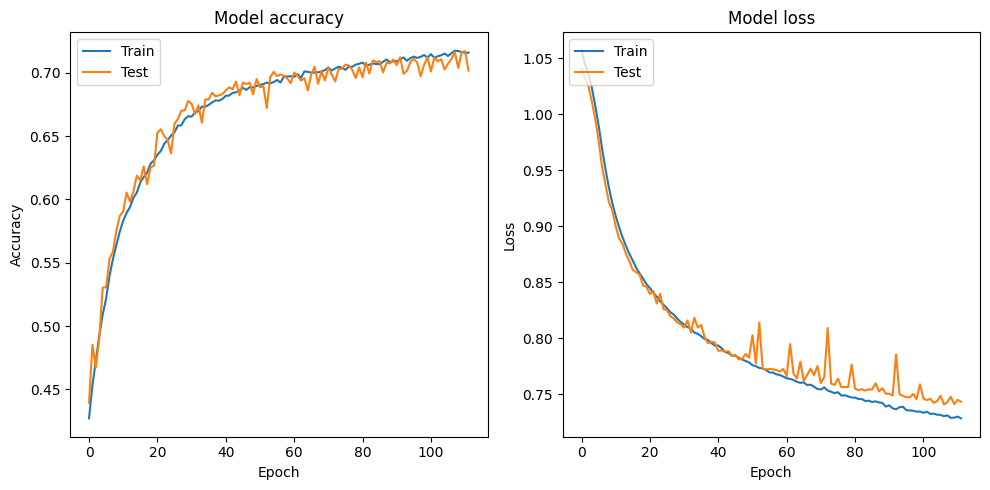

In [ ]:
plot_filepath = '/content/drive/MyDrive/ASC/results/plots/'

# Assuming 'history' contains your training history
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])  # Use 'acc' instead of 'accuracy'
plt.plot(history.history['val_accuracy'])  # Use 'val_acc' instead of 'val_accuracy'
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.savefig(plot_filepath+'metrcis.jpg')
plt.savefig(plot_filepath+'metrcis.svg')

plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_test[:9800] represents the true labels for the first 9800 samples
# Modify it accordingly if your true labels cover a different range

sentiment_mapping = {1: 'Neutral', 0: 'Negative', 2: 'Positive'}

predicted_probs = model.predict(X_t)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Compute precision, recall, and f1 score for each class
precision = precision_score(y_test[:9800], predicted_labels, average=None)
recall = recall_score(y_test[:9800], predicted_labels, average=None)
f1 = f1_score(y_test[:9800], predicted_labels, average=None)
metrics_dictionary = {'precision': precision,
                      'recall': recall,
                      'f1': f1
                      }
dataframe = pd.DataFrame(metrics_dictionary)
dataframe.to_csv(plot_filepath+'metrics.csv')


# Print precision, recall, and f1 score for each class
for i in range(len(precision)):
    sentiment_class = sentiment_mapping[i]
    print(f'Sentiment Class "{sentiment_class}":')
    print(f'  Precision: {precision[i]}')
    print(f'  Recall: {recall[i]}')
    print(f'  F1 Score: {f1[i]}')


307/307 [==============================] - 0s 1ms/step
Sentiment Class "Negative":
  Precision: 0.48119692680954307
  Recall: 0.37327478042659973
  F1 Score: 0.42042042042042044
Sentiment Class "Neutral":
  Precision: 0.44250780437044746
  Recall: 0.5187557182067704
  F1 Score: 0.4776077495437316
Sentiment Class "Positive":
  Precision: 0.6080964685615848
  Recall: 0.6354635463546354
  F1 Score: 0.6214788732394366


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from prettytable import PrettyTable

# Assuming y_test[:9800] represents the true labels for the first 9800 samples
# Modify it accordingly if your true labels cover a different range

sentiment_mapping = {1: 'Neutral', 0: 'Negative', 2: 'Positive'}

predicted_probs = model.predict(X_t)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Compute precision, recall, and f1 score for each class
precision = precision_score(y_test[:9800], predicted_labels, average=None)
recall = recall_score(y_test[:9800], predicted_labels, average=None)
f1 = f1_score(y_test[:9800], predicted_labels, average=None)

# Create a table
table = PrettyTable()
table.field_names = ["Sentiment Class", "Precision", "Recall", "F1 Score"]

# Populate the table with data
for i in range(len(precision)):
    sentiment_class = sentiment_mapping[i]
    table.add_row([sentiment_class, precision[i], recall[i], f1[i]])

# Print the table
print(table)


307/307 [==============================] - 0s 1ms/step
+-----------------+---------------------+---------------------+---------------------+
| Sentiment Class |      Precision      |        Recall       |       F1 Score      |
+-----------------+---------------------+---------------------+---------------------+
|     Negative    | 0.48119692680954307 | 0.37327478042659973 | 0.42042042042042044 |
|     Neutral     | 0.44250780437044746 |  0.5187557182067704 |  0.4776077495437316 |
|     Positive    |  0.6080964685615848 |  0.6354635463546354 |  0.6214788732394366 |
+-----------------+---------------------+---------------------+---------------------+


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from prettytable import PrettyTable

# Separate data based on the aspect
y_true_aspect_1, y_true_aspect_2 = [], []
x_true_aspect_1, x_true_aspect_2 = [], []
index = 0
tt = X_test['aspect'].tolist()

y_test = y_test.tolist()
for id in range(9800):  # Check if the index is within bounds
    if tt[id] == 'the teacher':
        x_true_aspect_1.append(X_t[id])
        y_true_aspect_1.append(y_test[id])
    else:
        x_true_aspect_2.append(X_t[id])
        y_true_aspect_2.append(y_test[id])


# Predict labels for each aspect
predicted_probs = model.predict(np.array(x_true_aspect_1))
predicted_labels_teacher = np.argmax(predicted_probs, axis=1)
predicted_probs = model.predict(np.array(x_true_aspect_2))
predicted_labels_course = np.argmax(predicted_probs, axis=1)

# Function to calculate and print scores
def print_scores(y_true, predicted_labels, aspect_name):
    precision = precision_score(y_true, predicted_labels, average=None)
    recall = recall_score(y_true, predicted_labels, average=None)
    f1 = f1_score(y_true, predicted_labels, average=None)

    table = PrettyTable()
    table.field_names = [f"{aspect_name} Class", "Precision", "Recall", "F1 Score"]

    for i in range(len(precision)):
        table.add_row([f'Class {i}', precision[i], recall[i], f1[i]])

    print(table)

# Assuming you have predicted_labels_teacher and predicted_labels_course defined somewhere in your code

# Print scores for 'the teacher' aspect
print("Scores for 'the teacher' aspect:")
print_scores(y_true_aspect_1, predicted_labels_teacher, 'the teacher')

# Print scores for 'the course' aspect
print("\nScores for 'the course' aspect:")
print_scores(y_true_aspect_2, predicted_labels_course, 'the course')


293/293 [==============================] - 0s 1ms/step
Scores for 'the teacher' aspect:
+-------------------+---------------------+---------------------+---------------------+
| the teacher Class |      Precision      |        Recall       |       F1 Score      |
+-------------------+---------------------+---------------------+---------------------+
|      Class 0      |  0.5526315789473685 | 0.44366197183098594 | 0.49218750000000006 |
|      Class 1      | 0.48847926267281105 |  0.7066666666666667 |  0.5776566757493188 |
|      Class 2      |  0.5047619047619047 |  0.3680555555555556 | 0.42570281124497994 |
+-------------------+---------------------+---------------------+---------------------+

Scores for 'the course' aspect:
+------------------+---------------------+--------------------+---------------------+
| the course Class |      Precision      |       Recall       |       F1 Score      |
+------------------+---------------------+--------------------+---------------------+
|    



---



# Use bert to extract features

In [ ]:
x_tt = X_test['processed_review'].tolist()
x_tt = x_tt[:9800]

In [ ]:
x = X_train['processed_review'].tolist()
x = x[:39400]

In [ ]:
from transformers import BertTokenizer, BertModel
import torch


# Load BERT model and tokenizer
device="cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)
BATCH_SIZE=512#@param{type"slider",min:64,max:1024,step:16}
if model.device =="cpu":
  raise ValueError("Cuda not set up properly")


# Define a function for batching and processing
def process_batch(texts, max_length=512, batch_size=BATCH_SIZE ,title='train_bert'):
    tokenized_texts = [tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=max_length) for text in texts]
    max_len = max(len(tokens) for tokens in tokenized_texts)
    padded_texts = [tokens + [0] * (max_len - len(tokens)) for tokens in tokenized_texts]
    input_ids = torch.tensor(padded_texts)

    # Process in batches with tqdm
    batches = [input_ids[i:i+batch_size] for i in range(39400, len(input_ids), batch_size)]
    bert_embeddings = []
    id =0
    # Add tqdm for progress bar
    model.eval()
    with torch.inference_mode():
      for batch in tqdm(batches, desc="Processing batches", leave=False):
          outputs = model(batch.to(device))
          with open(f'/content/drive/MyDrive/ASC/dataset/{title}/{id}.pkl', 'wb') as f:
             pickle.dump(outputs.last_hidden_state, f)
          id +=1

    return



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def load_hidden_state_batch(filepaths):
    results = []

    for filepath in tqdm(filepaths, desc="Loading hidden state batches"):
        result = load_from_pickle(filepath).to(dtype=torch.float16)
        # torch.cuda.empty_cache()  # Empty cache to release any unused memory
        result = result.to(torch.device("cpu")).detach().numpy()
        results.append(result)

    return results

**train**

In [ ]:
process_batch(x)

In [ ]:
filepaths = [f"/content/drive/MyDrive/ASC/dataset/train_bert/{i}.pkl" for i in range(77)]
X_bert_train = load_hidden_state_batch(filepaths)

Loading hidden state batches:   0%|          | 0/77 [00:00<?, ?it/s]

In [ ]:
X_bert_train = np.concatenate(X_bert_train, axis=0)
gc.collect()
X_bert_train.shape

In [ ]:
X_bert_train = X_bert_train.reshape((39400, 393216))

In [ ]:
with open('/content/drive/MyDrive/ASC/dataset/train_bert.pkl', 'wb') as f:
    pickle.dump(X_bert_train, f)

In [ ]:
X_bert_train = []
with (open('/content/drive/MyDrive/ASC/dataset/train_bert.pkl', "rb")) as openfile:
    while True:
        try:
            X_bert_train.append(pickle.load(openfile))
        except EOFError:
            break

In [ ]:
X_bert_train = np.array(X_bert_train[0])

In [ ]:
X_bert_train.shape

In [ ]:
X_parallel.shape

In [ ]:
chunk_size = 1000
num_chunks = (X_bert_train.shape[0] + chunk_size - 1) // chunk_size

X_bert_concat = np.empty((X_bert_train.shape[0], X_bert_train.shape[1] + X_parallel.shape[1]), dtype=X_bert_train.dtype)

for i in range(num_chunks):
    start = i * chunk_size
    end = min(start + chunk_size, X_bert_train.shape[0])

    X_chunk = np.concatenate((X_bert_train[start:end], X_parallel[start:end]), axis=1)  # Concatenate corresponding chunks
    X_bert_concat[start:end] = X_chunk
del X_bert_train
del X_parallel

In [ ]:
# with open('/content/drive/MyDrive/ASC/dataset/final_train_bert.pkl', 'wb') as f:
#     pickle.dump(X_bert_concat, f)
# del X_bert_concat

In [ ]:
X_final_train_bert = []
with (open('/content/drive/MyDrive/ASC/dataset/final_train_bert.pkl', "rb")) as openfile:
    while True:
        try:
            X_final_train_bert.append(pickle.load(openfile))
        except EOFError:
            break

In [ ]:
X_final_train_bert = np.array(X_final_train_bert[0])

In [ ]:
X_final_train_bert.shape

(39400, 393816)

**test**

In [ ]:
process_batch(np.concatenate((x, x_tt), axis=0) , title="test_bert")

Processing batches:   0%|          | 0/20 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [ ]:
filepaths = [f"/content/drive/MyDrive/ASC/dataset/test_bert/{i}.pkl" for i in range(20)]
X_bert_test = load_hidden_state_batch(filepaths)

Loading hidden state batches:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
len(X_bert_test[0][0][0])

768

In [ ]:
X_bert_test = np.concatenate(X_bert_test, axis=0)
gc.collect()
X_bert_test.shape

(9800, 512, 768)

In [ ]:
512 * 768

393216

In [ ]:
X_bert_test = X_bert_test.reshape((9800, 393216))

In [ ]:
# with open('/content/drive/MyDrive/ASC/dataset/test_bert.pkl', 'wb') as f:
#     pickle.dump(X_bert_test, f)

In [ ]:
X_bert_test = []
with (open('/content/drive/MyDrive/ASC/dataset/test_bert.pkl', "rb")) as openfile:
    while True:
        try:
            X_bert_test.append(pickle.load(openfile))
        except EOFError:
            break

In [ ]:
X_bert_test = np.array(X_bert_test[0])

In [ ]:
X_bert_test.shape

(9800, 393216)

In [ ]:
X_t.shape

(9800, 600)

In [ ]:
chunk_size = 1000
num_chunks = (X_bert_test.shape[0] + chunk_size - 1) // chunk_size

X_bert_concat_t = np.empty((X_bert_test.shape[0], X_bert_test.shape[1] + X_t.shape[1]), dtype=X_bert_test.dtype)

for i in range(num_chunks):
    start = i * chunk_size
    end = min(start + chunk_size, X_bert_test.shape[0])

    X_chunk = np.concatenate((X_bert_test[start:end], X_t[start:end]), axis=1)  # Concatenate corresponding chunks
    X_bert_concat_t[start:end] = X_chunk
del X_bert_test
del X_t

In [ ]:
with open('/content/drive/MyDrive/ASC/dataset/final_test_bert.pkl', 'wb') as f:
    pickle.dump(X_bert_concat_t, f)
del X_bert_concat_t

In [ ]:
X_final_test_bert = []
with (open('/content/drive/MyDrive/ASC/dataset/final_test_bert.pkl', "rb")) as openfile:
    while True:
        try:
            X_final_test_bert.append(pickle.load(openfile))
        except EOFError:
            break

In [ ]:
X_final_test_bert = np.array(X_final_test_bert[0])


In [ ]:
X_final_test_bert.shape

(9800, 393816)

# Deep Learning models

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping,Callback,CSVLogger
import gc
class GarbageCollectorCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Reshape, Conv1D, GlobalAveragePooling1D, Dense

In [ ]:
try:
    with open('/content/drive/MyDrive/ASC/dataset/final_train_bert.pkl', "rb") as f:
        X_final_train_bert = np.load(f, allow_pickle=True)
except IOError:  # Handle potential errors during loading
    X_final_train_bert = []

# EXP1

In [ ]:
def generator(data, labels, batch_size):
  while True:
    indices = np.random.permutation(len(data))
    for i in range(0, len(indices), batch_size):
      batch_indices = indices[i:i + batch_size]
      yield data[batch_indices], labels[batch_indices]

model = Sequential([
    Dense(4, input_shape=(393816,), activation='linear'),
])

for _ in range(4):
    model.add(Dense(units=64, activation='relu'))

model.add(Dense(3, activation='softmax'))


loss_function = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

checkpoint_filepath = '/content/drive/MyDrive/ASC/results/models/exp1/'
if not os.path.exists(checkpoint_filepath):
  os.mkdir(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_weights_epoch{epoch:02d}_val_acc{val_accuracy:.4f}.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history_logger_1 = CSVLogger(os.path.join(checkpoint_filepath,'history1.csv'), separator=",", append=True)
checkpoint_1 = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
es_1 = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list_1 = [GarbageCollectorCallback(),model_checkpoint_callback, history_logger_1]

validation_split = 0.1  # You can adjust this based on your needs
num_validation_samples = int(validation_split * len(X_final_train_bert))

X_train = X_final_train_bert[:-num_validation_samples]
y_train = y_enc[:-num_validation_samples]
X_validation = X_final_train_bert[-num_validation_samples:]
y_validation = y_enc[-num_validation_samples:]


batch_size = 256
history = model.fit_generator(
    generator=generator(X_train, y_train, batch_size),
    epochs=500,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=generator(X_validation, y_validation, batch_size),  # Use generator for validation data as well
    validation_steps=len(X_validation) // batch_size,
    callbacks=callbacks_list_1
)

<ipython-input-32-5a790787681f>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/500
138/138 [==============================] - 78s 557ms/step - loss: 5.9007 - accuracy: 0.3335 - val_loss: 6.0066 - val_accuracy: 0.3438
Epoch 2/500
138/138 [==============================] - 75s 549ms/step - loss: 2.7884 - accuracy: 0.3510 - val_loss: 1.0667 - val_accuracy: 0.4260
Epoch 3/500
138/138 [==============================] - 74s 539ms/step - loss: 2.4026 - accuracy: 0.3642 - val_loss: 1.0871 - val_accuracy: 0.4305
Epoch 4/500
138/138 [==============================] - 74s 539ms/step - loss: 1.2349 - accuracy: 0.3791 - val_loss: 1.2410 - val_accuracy: 0.4490
Epoch 5/500
138/138 [==============================] - 74s 539ms/step - loss: 1.1358 - accuracy: 0.3953 - val_loss: 1.0376 - val_accuracy: 0.4568
Epoch 6/500
138/138 [==============================] - 74s 540ms/step - loss: 1.0751 - accuracy: 0.4187 - val_loss: 1.0243 - val_accuracy: 0.4750
Epoch 7/500
138/138 [==============================] - 74s 538ms/step - loss: 1.1037 - accuracy: 0.4255 - val_loss: 1.0149 -

# EXP2

In [ ]:
def generator(data, labels, batch_size):
  while True:
    indices = np.random.permutation(len(data))
    for i in range(0, len(indices), batch_size):
      batch_indices = indices[i:i + batch_size]
      yield data[batch_indices], labels[batch_indices]

model = Sequential([
    Dense(4, input_shape=(393816,), activation='linear'),
])

for _ in range(6):
    model.add(Dense(units=64, activation='relu'))

model.add(Dense(3, activation='softmax'))


loss_function = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])


checkpoint_filepath = '/content/drive/MyDrive/ASC/results/models/exp2/'
if not os.path.exists(checkpoint_filepath):
  os.mkdir(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_weights_epoch{epoch:02d}_val_acc{val_accuracy:.4f}.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history_logger_1 = CSVLogger(os.path.join(checkpoint_filepath,'history1.csv'), separator=",", append=True)
#checkpoint_1 = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
es_1 = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list_1 = [GarbageCollectorCallback(),model_checkpoint_callback, history_logger_1]

validation_split = 0.1  # You can adjust this based on your needs
num_validation_samples = int(validation_split * len(X_final_train_bert))

X_train = X_final_train_bert[:-num_validation_samples]
y_train = y_enc[:-num_validation_samples]
X_validation = X_final_train_bert[-num_validation_samples:]
y_validation = y_enc[-num_validation_samples:]


batch_size = 256
history = model.fit_generator(
    generator=generator(X_train, y_train, batch_size),
    epochs=500,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=generator(X_validation, y_validation, batch_size),  # Use generator for validation data as well
    validation_steps=len(X_validation) // batch_size,
    callbacks=callbacks_list_1
)

<ipython-input-13-b7e99e6f9de4>:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/500
138/138 [==============================] - 109s 768ms/step - loss: 2.8541 - accuracy: 0.3352 - val_loss: 1.3848 - val_accuracy: 0.3411
Epoch 2/500
138/138 [==============================] - 104s 759ms/step - loss: 1.3196 - accuracy: 0.3610 - val_loss: 1.0393 - val_accuracy: 0.4688
Epoch 3/500
138/138 [==============================] - 104s 761ms/step - loss: 1.2025 - accuracy: 0.3835 - val_loss: 1.0675 - val_accuracy: 0.4135
Epoch 4/500
138/138 [==============================] - 104s 759ms/step - loss: 1.0973 - accuracy: 0.4141 - val_loss: 1.0384 - val_accuracy: 0.4503
Epoch 5/500
138/138 [==============================] - 104s 761ms/step - loss: 1.0721 - accuracy: 0.4254 - val_loss: 1.0532 - val_accuracy: 0.4396
Epoch 6/500
138/138 [==============================] - 104s 758ms/step - loss: 1.0511 - accuracy: 0.4417 - val_loss: 0.9975 - val_accuracy: 0.4734
Epoch 7/500
138/138 [==============================] - 104s 760ms/step - loss: 1.0493 - accuracy: 0.4443 - val_loss: 0

#EXP3

In [ ]:
def generator(data, labels, batch_size):
  while True:
    indices = np.random.permutation(len(data))
    for i in range(0, len(indices), batch_size):
      batch_indices = indices[i:i + batch_size]
      yield data[batch_indices], labels[batch_indices]

model = Sequential([
    Dense(4, input_shape=(393816,), activation='linear'),
])

for _ in range(10):
    model.add(Dense(units=64, activation='relu'))

model.add(Dense(3, activation='softmax'))


loss_function = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)


model.compile( loss=loss_function, metrics=['accuracy'])

model.load_weights(os.path.join('/content/drive/MyDrive/ASC/results/models/exp3/', 'f_model_weights_epoch170_val_acc0.7909.h5'))

checkpoint_filepath = '/content/drive/MyDrive/ASC/results/models/exp3/'
if not os.path.exists(checkpoint_filepath):
  os.mkdir(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'z_model_weights_epoch{epoch:02d}_val_acc{val_accuracy:.4f}.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history_logger_1 = CSVLogger(os.path.join(checkpoint_filepath,'history1.csv'), separator=",", append=True)
checkpoint_1 = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
es_1 = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list_1 = [GarbageCollectorCallback(),model_checkpoint_callback, history_logger_1]

validation_split = 0.1  # You can adjust this based on your needs
num_validation_samples = int(validation_split * len(X_final_train_bert))

X_train = X_final_train_bert[:-num_validation_samples]
y_train = y_enc[:-num_validation_samples]
X_validation = X_final_train_bert[-num_validation_samples:]
y_validation = y_enc[-num_validation_samples:]


batch_size = 256
history = model.fit_generator(
    generator=generator(X_train, y_train, batch_size),
    epochs=500,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=generator(X_validation, y_validation, batch_size),  # Use generator for validation data as well
    validation_steps=len(X_validation) // batch_size,
    callbacks=callbacks_list_1
)

<ipython-input-13-ee2be7a4d290>:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/500
138/138 [==============================] - 121s 864ms/step - loss: 0.6023 - accuracy: 0.7599 - val_loss: 0.6745 - val_accuracy: 0.7143
Epoch 2/500
138/138 [==============================] - 115s 836ms/step - loss: 0.5669 - accuracy: 0.7783 - val_loss: 0.5785 - val_accuracy: 0.7885
Epoch 3/500
138/138 [==============================] - 113s 825ms/step - loss: 0.5582 - accuracy: 0.7830 - val_loss: 0.6587 - val_accuracy: 0.7471
Epoch 4/500
138/138 [==============================] - 121s 886ms/step - loss: 0.5737 - accuracy: 0.7724 - val_loss: 0.8018 - val_accuracy: 0.7135
Epoch 5/500
138/138 [==============================] - 117s 851ms/step - loss: 0.5812 - accuracy: 0.7699 - val_loss: 0.5609 - val_accuracy: 0.7870
Epoch 6/500
138/138 [==============================] - 117s 857ms/step - loss: 0.5867 - accuracy: 0.7675 - val_loss: 0.6156 - val_accuracy: 0.7737
Epoch 7/500
138/138 [==============================] - 117s 857ms/step - loss: 0.5694 - accuracy: 0.7743 - val_loss: 0

#EXP4

In [ ]:
def generator(data, labels, batch_size):
  while True:
    indices = np.random.permutation(len(data))
    for i in range(0, len(indices), batch_size):
      batch_indices = indices[i:i + batch_size]
      yield data[batch_indices], labels[batch_indices]

model = Sequential([
    Dense(4, input_shape=(393816,), activation='linear'),
])

for _ in range(15):
    model.add(Dense(units=64, activation='relu'))

model.add(Dense(3, activation='softmax'))


loss_function = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)


model.compile( loss=loss_function, metrics=['accuracy'])

# model.load_weights(os.path.join('/content/drive/MyDrive/ASC/results/models/exp3/', 'f_model_weights_epoch170_val_acc0.7909.h5'))

checkpoint_filepath = '/content/drive/MyDrive/ASC/results/models/exp4/'
if not os.path.exists(checkpoint_filepath):
  os.mkdir(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'z_model_weights_epoch{epoch:02d}_val_acc{val_accuracy:.4f}.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history_logger_1 = CSVLogger(os.path.join(checkpoint_filepath,'history1.csv'), separator=",", append=True)
checkpoint_1 = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
es_1 = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list_1 = [GarbageCollectorCallback(),model_checkpoint_callback, history_logger_1]

validation_split = 0.1  # You can adjust this based on your needs
num_validation_samples = int(validation_split * len(X_final_train_bert))

X_train = X_final_train_bert[:-num_validation_samples]
y_train = y_enc[:-num_validation_samples]
X_validation = X_final_train_bert[-num_validation_samples:]
y_validation = y_enc[-num_validation_samples:]


batch_size = 256
history = model.fit_generator(
    generator=generator(X_train, y_train, batch_size),
    epochs=1000,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=generator(X_validation, y_validation, batch_size),  # Use generator for validation data as well
    validation_steps=len(X_validation) // batch_size,
    callbacks=callbacks_list_1
)

<ipython-input-13-507b1e3a1ba6>:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/1000
138/138 [==============================] - 125s 873ms/step - loss: 1.0983 - accuracy: 0.3428 - val_loss: 1.0948 - val_accuracy: 0.3547
Epoch 2/1000
138/138 [==============================] - 119s 866ms/step - loss: 1.0826 - accuracy: 0.3938 - val_loss: 1.0782 - val_accuracy: 0.3292
Epoch 3/1000
138/138 [==============================] - 119s 867ms/step - loss: 1.0530 - accuracy: 0.4272 - val_loss: 1.1327 - val_accuracy: 0.3208
Epoch 4/1000
138/138 [==============================] - 120s 872ms/step - loss: 1.0507 - accuracy: 0.4355 - val_loss: 1.0182 - val_accuracy: 0.4815
Epoch 5/1000
138/138 [==============================] - 119s 865ms/step - loss: 1.0364 - accuracy: 0.4465 - val_loss: 1.3076 - val_accuracy: 0.3260
Epoch 6/1000
138/138 [==============================] - 119s 867ms/step - loss: 1.0395 - accuracy: 0.4467 - val_loss: 1.0217 - val_accuracy: 0.4781
Epoch 7/1000
138/138 [==============================] - 119s 865ms/step - loss: 1.0405 - accuracy: 0.4432 - val_

In [ ]:
_validation.shape

(3940, 3)

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')
# Clear GPU memory
K.clear_session()
def generator(data, labels, batch_size):
    while True:
        indices = np.random.permutation(len(data))
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i + batch_size]
            yield data[batch_indices].astype('float16'), labels[batch_indices].astype('float16')


from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, Dropout, Reshape, Conv1D, MaxPooling1D

# Create the Sequential model
model = Sequential()

# Input Layer
model.add(Dense(4, input_shape=(393816,), activation='linear'))

# Hidden Layers
model.add(Dense(units=128, activation='relu'))
model.add(Reshape((128, 1)))  # Add Reshape layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D())
model.add(GlobalAveragePooling1D())

for _ in range(5):  # Reduced the number of dropout layers
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.2))

model.add(Dense(units=4, activation='relu'))

# Output Layer
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


optimizer = Adam(learning_rate=0.001)

# Compile the model with mixed precision and appropriate loss and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

validation_split = 0.1  # You can adjust this based on your needs
num_validation_samples = int(validation_split * len(X_final_train_bert))

def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_pred = tf.cast(y_pred, tf.float32)

    epsilon = 1e-10
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    cross_entropy_loss = -tf.reduce_sum(tf.cast(y_true, tf.float32) * tf.math.log(y_pred))

    total_loss = cross_entropy_loss

    return total_loss
# Compile the model with appropriate loss and metrics
#model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

#optimizer = Adam(learning_rate=0.001)  # Adjust learning rate as needed
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '/content/drive/MyDrive/ASC/results/models/DLA1/'
if not os.path.exists(checkpoint_filepath):
  os.mkdir(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_weights_epoch{epoch:02d}.h5'),
    save_weights_only=True,  # Save only the model weights
    save_best_only=True,      # Save only the best model
    monitor='val_accuracy',      # Monitor a specific metric (e.g., validation loss)
    mode='max',              # Mode for monitoring (minimize the monitored quantity)
    verbose=1                 # Verbosity level (1: display messages)
)
history_logger_1 = CSVLogger(os.path.join(checkpoint_filepath,'history1.csv'), separator=",", append=True)
checkpoint_1 = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
#es_1 = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list_1 = [GarbageCollectorCallback(),model_checkpoint_callback,history_logger_1]


X_train = X_final_train_bert[:-num_validation_samples]
y_train = y_enc[:-num_validation_samples]
X_validation = X_final_train_bert[-num_validation_samples:]
y_validation = y_enc[-num_validation_samples:]


batch_size = 8
history = model.fit_generator(
    generator=generator(X_train, y_train, batch_size),
    epochs=200,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=generator(X_validation, y_validation, batch_size),  # Use generator for validation data as well
    validation_steps=len(X_validation) // batch_size,
    callbacks=callbacks_list_1
)

Epoch 1/200


<ipython-input-23-43268f0e32e1>:95: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


4430/4432 [============================>.] - ETA: 0s - loss: 1.0990 - accuracy: 0.3363
Epoch 1: val_accuracy improved from -inf to 0.33003, saving model to /content/drive/MyDrive/ASC/results/models/DLA1/model_weights_epoch01.h5
4432/4432 [==============================] - 74s 16ms/step - loss: 1.0990 - accuracy: 0.3362 - val_loss: 1.0995 - val_accuracy: 0.3300
Epoch 2/200
4431/4432 [============================>.] - ETA: 0s - loss: 1.0988 - accuracy: 0.3339
Epoch 2: val_accuracy improved from 0.33003 to 0.34257, saving model to /content/drive/MyDrive/ASC/results/models/DLA1/model_weights_epoch02.h5
4432/4432 [==============================] - 67s 15ms/step - loss: 1.0988 - accuracy: 0.3339 - val_loss: 1.0986 - val_accuracy: 0.3426
Epoch 3/200
4430/4432 [============================>.] - ETA: 0s - loss: 1.0997 - accuracy: 0.3321
Epoch 3: val_accuracy did not improve from 0.34257
4432/4432 [==============================] - 68s 15ms/step - loss: 1.0997 - accuracy: 0.3321 - val_loss: 1.09

In [ ]:
def generator(data, labels, batch_size):
  while True:
    indices = np.random.permutation(len(data))  # Shuffle indices
    for i in range(0, len(indices), batch_size):
      batch_indices = indices[i:i + batch_size]
      yield data[batch_indices], labels[batch_indices]

# model = Sequential([
#     Dense(4, input_shape=(393816,), activation='linear'),
# ])

# # Adding Batch Normalization for stability
# model.add(BatchNormalization())

# # Adding ten additional Dense layers with ReLU activation and Dropout
# for _ in range(10):
#     model.add(Dense(units=64, activation='relu'))
#     model.add(Dropout(0.2))  # Adjust dropout rate as needed

# model.add(Dense(3, activation='softmax'))

model = Sequential()

# Updated input shape based on PCA components
model.add(Dense(64, input_shape=(393816,), activation='linear'))  # Increased units and changed activation
#model.add(BatchNormalization())

for _ in range(8):  # Reduced to 8 additional layers for simplicity
    model.add(Dense(units=128, activation='relu'))  # Increased units
    model.add(Dropout(0.2))  # Adjusted dropout rate

# Reduced final layer units based on problem requirements
model.add(Dense(3, activation='softmax'))

# Optimized hyperparameters
optimizer = Adam(learning_rate=0.001)  #

validation_split = 0.1  # You can adjust this based on your needs
num_validation_samples = int(validation_split * len(X_final_train_bert))

def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_pred = tf.cast(y_pred, tf.float32)

    epsilon = 1e-10
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    cross_entropy_loss = -tf.reduce_sum(tf.cast(y_true, tf.float32) * tf.math.log(y_pred))

    total_loss = cross_entropy_loss

    return total_loss
# Compile the model with appropriate loss and metrics
#model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

optimizer = Adam(learning_rate=0.001)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '/content/drive/MyDrive/ASC/results/models/DLA3/'
if not os.path.exists(checkpoint_filepath):
  os.mkdir(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_weights_epoch{epoch:02d}.h5'),
    save_weights_only=True,  # Save only the model weights
    save_best_only=True,      # Save only the best model
    monitor='val_loss',      # Monitor a specific metric (e.g., validation loss)
    mode='min',              # Mode for monitoring (minimize the monitored quantity)
    verbose=1                 # Verbosity level (1: display messages)
)

history_logger_1 = CSVLogger(os.path.join(checkpoint_filepath,'history1.csv'), separator=",", append=True)
checkpoint_1 = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
#es_1 = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list_1 = [GarbageCollectorCallback(),model_checkpoint_callback, history_logger_1]


X_train = X_final_train_bert[:-num_validation_samples]
y_train = y_enc[:-num_validation_samples]
X_validation = X_final_train_bert[-num_validation_samples:]
y_validation = y_enc[-num_validation_samples:]


batch_size = 16
history = model.fit_generator(
    generator=generator(X_train, y_train, batch_size),
    epochs=200,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=generator(X_validation, y_validation, batch_size),  # Use generator for validation data as well
    validation_steps=len(X_validation) // batch_size,
    callbacks=callbacks_list_1
)

Epoch 1/200


<ipython-input-25-6529f6d0af41>:84: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


2215/2216 [============================>.] - ETA: 0s - loss: 1.4422 - accuracy: 0.3502
Epoch 1: val_loss improved from inf to 1.07662, saving model to /content/drive/MyDrive/ASC/results/models/DLA3/model_weights_epoch01.h5
2216/2216 [==============================] - 74s 32ms/step - loss: 1.4420 - accuracy: 0.3502 - val_loss: 1.0766 - val_accuracy: 0.4116
Epoch 2/200
2216/2216 [==============================] - ETA: 0s - loss: 1.0938 - accuracy: 0.3595
Epoch 2: val_loss improved from 1.07662 to 1.06528, saving model to /content/drive/MyDrive/ASC/results/models/DLA3/model_weights_epoch02.h5
2216/2216 [==============================] - 68s 31ms/step - loss: 1.0938 - accuracy: 0.3595 - val_loss: 1.0653 - val_accuracy: 0.4220
Epoch 3/200
2216/2216 [==============================] - ETA: 0s - loss: 1.0943 - accuracy: 0.3485
Epoch 3: val_loss did not improve from 1.06528
2216/2216 [==============================] - 66s 30ms/step - loss: 1.0943 - accuracy: 0.3485 - val_loss: 1.0993 - val_accu

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
import os

def generator(data, labels, batch_size):
    while True:
        indices = np.random.permutation(len(data))  # Shuffle indices
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i + batch_size]
            yield data[batch_indices], labels[batch_indices]
def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_pred = tf.cast(y_pred, tf.float32)

    epsilon = 1e-10
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    cross_entropy_loss = -tf.reduce_sum(tf.cast(y_true, tf.float32) * tf.math.log(y_pred))

    total_loss = cross_entropy_loss


# Incremental PCA and scaling in batches
batch_size_pca = 500  # Adjust as needed
incremental_pca = IncrementalPCA(n_components=100, batch_size=batch_size_pca)
scaler = StandardScaler()

X_train_pca = []
# ... (previous code unchanged)

for i in range(0, len(X_final_train_bert), batch_size_pca):
    X_batch = X_final_train_bert[i:i + batch_size_pca]
    X_batch_scaled = scaler.partial_fit_transform(X_batch)  # Incremental scaling and transformation
    X_batch_pca = incremental_pca.partial_fit(X_batch_scaled)
    X_train_pca.append(X_batch_pca)

# ... (remaining code unchanged)

X_train_pca = np.concatenate(X_train_pca)  # Combine transformed batches

# ... (model definition and training as before, using generators)
model = Sequential()

# Updated input shape based on PCA components
model.add(Dense(64, input_shape=(100,), activation='relu'))  # Increased units and changed activation
model.add(BatchNormalization())

for _ in range(8):  # Reduced to 8 additional layers for simplicity
    model.add(Dense(units=128, activation='relu'))  # Increased units
    model.add(Dropout(0.3))  # Adjusted dropout rate

# Reduced final layer units based on problem requirements
model.add(Dense(3, activation='softmax'))

# Optimized hyperparameters
optimizer = Adam(learning_rate=0.001)  # Adjust learning rate as needed
model.compile( loss=custom_loss , metrics=['accuracy'])

checkpoint_filepath = '/content/drive/MyDrive/ASC/results/models/PCA/'
os.makedirs(checkpoint_filepath, exist_ok=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_weights_epoch{epoch:02d}.h5'),
    save_weights_only=True,  # Save only the model weights
    save_best_only=True,      # Save only the best model
    monitor='val_loss',      # Monitor a specific metric (e.g., validation loss)
    mode='min',              # Mode for monitoring (minimize the monitored quantity)
    verbose=1                 # Verbosity level (1: display messages)
)

validation_split = 0.1  # You can adjust this based on your needs
num_validation_samples = int(validation_split * len(X_final_train_bert))

X_train = X_train_pca[:-num_validation_samples]
y_train = y_enc[:-num_validation_samples]
X_validation = X_train_pca[-num_validation_samples:]
y_validation = y_enc[-num_validation_samples:]

batch_size = 16
history = model.fit_generator(
    generator=generator(X_train, y_train, batch_size),
    epochs=200,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=generator(X_validation, y_validation, batch_size),  # Use generator for validation data as well
    validation_steps=len(X_validation) // batch_size,
    callbacks=[model_checkpoint_callback],
    verbose=2  # Set verbose to 2 for a more concise output
)


AttributeError: 'StandardScaler' object has no attribute 'partial_fit_transform'

In [ ]:
#



---

